In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from collections import Counter
import sys

from utils import nice_tree_plot, niceprint, permute_square, invert_permutation, without_diag
from compute_pam import compute_combo_tensor_pam, IndividualNodeAlphaCalc
from example_graphs import make_tree
from sim_data import PAMSampler, topics_griffiths_steyvers, ensure_anchor_words
from lda_collapsed_gibbs import CollapsedGibbs
from tree_extraction import Aho
from tree_extraction.Aho import get_ratio_matrix
from alpha_extract import AlphaExtract
from param_stats import topic_difference, find_flat_permutation, find_structural_permutation

from end_to_end import Analysis

In [2]:
np.random.seed(1)

## Outline

1. Set up parameters of the model (tree structure, alphas, and topic definitions -- anything else?)
2. Compute "true" co-occurrence matrix
3. Generate some simulated data by sampling from the model
  - Parameters: Number of documents, distribution over document sizes
4. Compute "empirical" co-occurrence matrix (using known per-word-slot topic assignments).  Compare to "true" co-occurrence matrix.
5. Apply LDA or anchor words to the simulated data -- estimate topics and co-occurrence matrix.  Compare "estimated" co-occurrence matrix to "true" and "empirical" matrices.  Compare "estimated" topics to "true" topics.
  - Parameters: number of topics; any other parameters needed for the chosen topic-estimation algorithm
6. Compute ratio matrix
7. Derive triplet constraints from ratio matrix
8. Apply Aho's algorithm to constraints, producing a tree where each leaf corresponds to a topic.  Compare to "true" tree structure.
9. Extract alpha parameters from co-occurrence matrix.  Compare to "true" alpha parameters.
  - Parameters: $\alpha_{max}$ and $\delta_{min}$ corresponding to hypothesis class
  
TODO: Find a way to remove # of topics as a parameter (eg, measure perplexity, and loop over different of # topics)

In [3]:
branching_factors = [2, 2, 2]
num_true_topics = np.prod(branching_factors)  # number of topics with which to generate data

true_tree = make_tree(branching_factors)
index_to_leaf = [x for x in true_tree.nodes() if true_tree.out_degree(x) == 0]
leaf_to_index = {leaf: idx for idx, leaf in enumerate(index_to_leaf)}

In [4]:
N = 10  # number of documents to generate
M = 20  # number of words per document
V = 25  # number of words in vocabulary
dim = 5  # size of "square" to use in defining topics
assert dim ** 2 == V

In [5]:
# N = 1000  # number of documents to generate
# M = 200  # number of words per document
# V = 100  # number of words in vocabulary
# dim = 10  # size of "square" to use in defining topics
# assert dim ** 2 == V

In [6]:
# N = 5000  # number of documents to generate
# M = 500  # number of words per document
# V = 100  # number of words in vocabulary
# dim = 10  # size of "square" to use in defining topics
# assert dim ** 2 == V

In [7]:
true_topics = topics_griffiths_steyvers(num_topics = num_true_topics, dimension = dim)

true_topics = ensure_anchor_words(true_topics)

In [8]:
true_alphas = {
    1: 1.0,                           2: 1.0,
    3: 1.0,         4: 1.0,           5: 1.0,           6: 1.0,
    7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0,
}

In [9]:
# Main user-selected parameters for training & extraction
num_topics_to_train = num_true_topics
delta_min = 0.1
alpha_max = 10.0
custom_prior = 1.3 ** np.arange(len(index_to_leaf))[::-1]

In [10]:
# topic_extraction_strategy = "CollapsedGibbs"
# topic_extraction_params = dict(alpha = custom_prior)

In [11]:
topic_extraction_strategy = "AnchorWords"
topic_extraction_params = dict()

In [12]:
a = Analysis(
    # Data generation params:
    true_tree = true_tree,
    true_alphas = true_alphas,
    num_docs = N,
    words_per_doc = M,
    vocab_size = V,
    true_topics = true_topics,
    leaf_to_index = leaf_to_index,
    # Extraction params:
    num_topics_to_train = num_topics_to_train,
    delta_min = delta_min,
    alpha_max = alpha_max,
    topic_extraction_strategy = topic_extraction_strategy,
    topic_extraction_params = topic_extraction_params,
)

In [13]:
a.run();

100%|██████████| 10/10 [00:00<00:00, 300.54it/s]

Input matrix shape: (25, 10)
identifying candidate anchors
0 candidates
Sum of entries in Q is  1.0000000000000002
Multiplying Q took  0.005421161651611328 seconds
Q sum is 1.0000000000000002
done reading documents
anchors are:
0 w00
1 w00
2 w00
3 w00
4 w00
5 w00
6 w00
7 w00


begin threaded recovery with 8 processors
0	-1	1.0
done recovering
w00 : w00 w07 w02 w11 w16 w20 w01 w04 w10 w08 
w00 : w07 w02 w11 w16 w20 w04 w01 w15 w10 w08 
w00 : w07 w02 w11 w16 w20 w04 w01 w15 w10 w08 
w00 : w07 w02 w11 w16 w20 w04 w01 w15 w10 w08 
w00 : w07 w02 w11 w16 w20 w04 w01 w15 w10 w08 
w00 : w07 w02 w11 w16 w20 w04 w01 w15 w10 w08 
w00 : w07 w02 w11 w16 w20 w04 w01 w15 w10 w08 
w00 : w07 w02 w11 w16 w20 w04 w01 w15 w10 w08 


## Display results

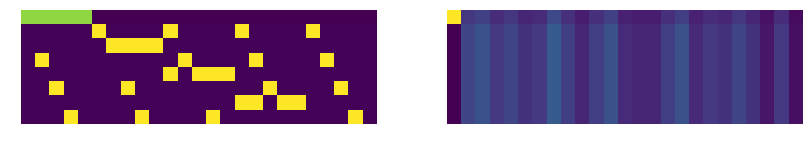

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(a.true_topics)
ax[0].axis('off')
ax[1].imshow(a.est_topics)
ax[1].axis('off')
None

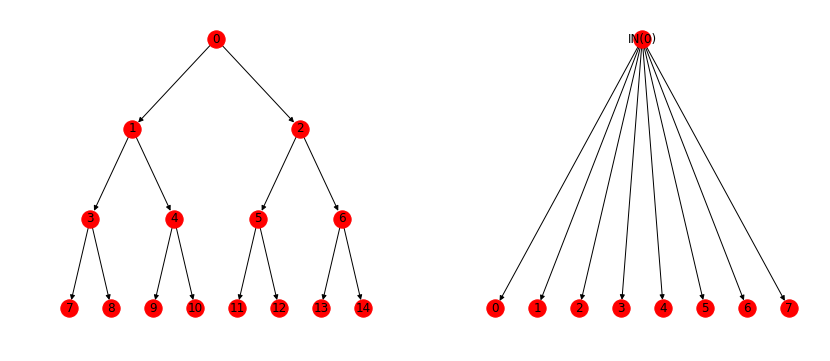

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
nice_tree_plot(a.true_tree, ax[0])
nice_tree_plot(a.est_tree, ax[1])

In [16]:
print(a.true_alphas)
print(a.est_alphas)

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0}
{0: -328.12858225904455, 1: -250.413183560711, 2: -249.41318356071093, 3: -248.4131835607109, 4: -247.41318356071088, 5: -246.413183560711, 6: -245.4131835607109, 7: -244.41318356071102}


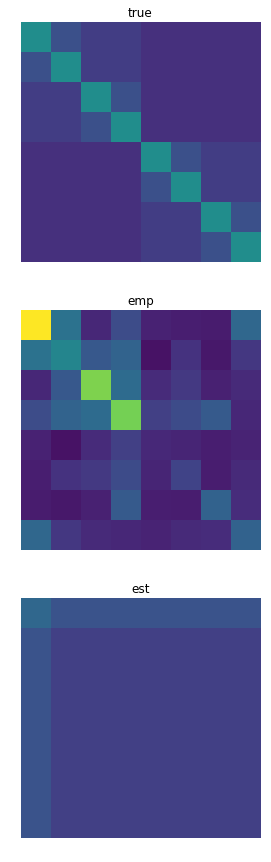

In [17]:
# Plot cooccurrence matrices
specs = [
    dict(name='true', cooccur=a.true_cooccur),
    dict(name='emp', cooccur=a.emp_cooccur),
    dict(name='est', cooccur=a.est_cooccur),
]

vmin=0.0
vmax=np.max([np.max(s["cooccur"]) for s in specs])

fig, ax = plt.subplots(len(specs), 1, figsize=(5, 5*len(specs)))
for i, spec in enumerate(specs):
    ax[i].imshow(spec["cooccur"], vmin=vmin, vmax=vmax)
    ax[i].axis('off')
    ax[i].set_title(spec["name"])

## Save results

In [18]:
a.save('results/results.pkl')

Saving to results/results_2019-05-09_at_15-44-09.pkl


## Find permutation that maps estimated topics to true topics

In [19]:
perm = find_flat_permutation(true_topics=a.true_topics, est_topics=a.est_topics)
perm

array([0, 1, 2, 3, 4, 5, 6, 7])

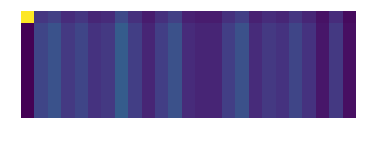

In [20]:
fig, ax = plt.subplots()
ax.imshow(a.est_topics[perm, :])
ax.axis('off')
None

In [21]:
est_cooccur_permuted = permute_square(X = a.est_cooccur, perm = perm)

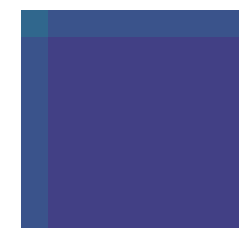

In [22]:
fig, ax = plt.subplots()
ax.imshow(est_cooccur_permuted, vmin=vmin, vmax=vmax)
ax.axis('off')
None

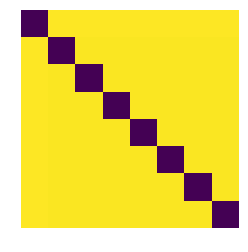

In [23]:
est_ratio_permuted = get_ratio_matrix(est_cooccur_permuted)

fig, ax = plt.subplots()
ax.imshow(without_diag(est_ratio_permuted))
ax.axis('off')
None

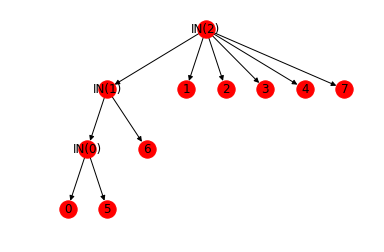

In [24]:
est_tree_permuted = Aho.extract(est_ratio_permuted, apply_ratio=False)
nice_tree_plot(est_tree_permuted)

## Compare results of alpha extraction

0.0004310617062610912

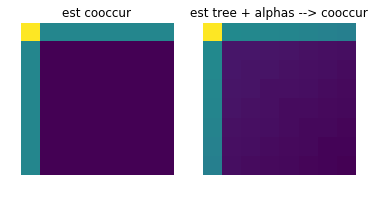

In [25]:
zzz = compute_combo_tensor_pam(a.est_tree, alpha=a.est_alphas)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(a.est_cooccur)
ax[0].axis('off')
ax[0].set_title('est cooccur')

ax[1].imshow(zzz)
ax[1].axis('off')
ax[1].set_title('est tree + alphas --> cooccur')

np.max(np.abs(zzz - est_cooccur_permuted))

0.09837889746060932

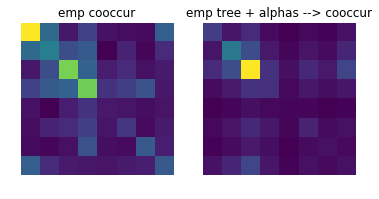

In [26]:
zzz = compute_combo_tensor_pam(a.emp_tree, alpha=a.emp_alphas)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(a.emp_cooccur)
ax[0].axis('off')
ax[0].set_title('emp cooccur')

ax[1].imshow(zzz)
ax[1].axis('off')
ax[1].set_title('emp tree + alphas --> cooccur')

np.max(np.abs(zzz - a.emp_cooccur))

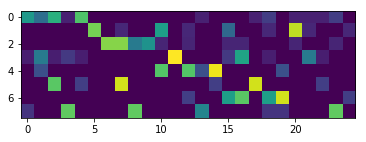

In [27]:
# Empirical estimate of topics
plt.imshow(a.emp_topics);

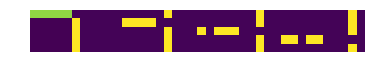

In [28]:
reshaped = np.hstack([x.reshape((dim, dim)) for x in a.true_topics])
fig, ax = plt.subplots()
ax.imshow(reshaped)
ax.axis('off')
None

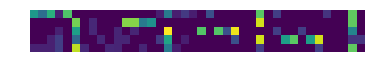

In [29]:
reshaped = np.hstack([x.reshape((dim, dim)) for x in a.emp_topics])
fig, ax = plt.subplots()
ax.imshow(reshaped)
ax.axis('off')
None

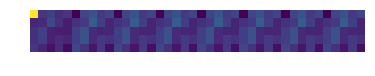

In [30]:
reshaped = np.hstack([x.reshape((dim, dim)) for x in a.est_topics[perm, :]])
fig, ax = plt.subplots()
ax.imshow(reshaped)
ax.axis('off')
None